# Exploratory analysis for federal contractors

This is just a simple exploratory analysis to get familiar with the Python language, docker containers, and Jupyter notebooks.  I've downloaded datasets from the [Federal Contractors Database](https://www.usaspending.gov/#/download_center/custom_award_data). For variable types, see the [data dictionary](http://fedspendingtransparency.github.io/dictionary-v1.1/).

[Track progress of the project on my trello board](https://trello.com/b/lZYSGp4M/federal-contractors-python)


While the goal is simply to get used to Python and some other technologies, I am interested in the specific question of ***what factors are the best predictors of minority owned companies***.  

#### Init
Read in the data and load packages

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp

dat = pd.read_csv('data/2017.csv', low_memory=False)

## Profiling

In [2]:
dat.shape

(72367, 225)

Since the data has 225 columns and +70k rows, I'm only going to do a profile report on a small subset of the rows.  I'm also going to save the report as an HTML file outside of this analysis.  

In [3]:
profile = pp.ProfileReport(dat.loc[0:10000])
profile.to_file(outputfile = "profiling/profile.html")

In [4]:
import matplotlib.pyplot as plt
cmt = dat.corr()

I'm mostly interested in dollars the companies recieve and the size of the company. So I'm going to make a function that checks for a certain level of correlation for the selected variable. The following cells look at:  

* Dollars Obligated
* Number of Employees
* Minority Owned Flag

In [5]:
def corMat(dd, corlv, var):
    ind = abs(dd[var]) > corlv
    return dd.loc[ind, ind]; 

In [6]:
corMat(cmt,0.05, "dollarsobligated").dollarsobligated

dollarsobligated                         1.000000
baseandexercisedoptionsvalue             0.967203
baseandalloptionsvalue                   0.861076
progsourcesubacct                       -0.076980
prime_awardee_executive1_compensation   -0.084980
prime_awardee_executive2_compensation   -0.072067
prime_awardee_executive3_compensation   -0.071098
prime_awardee_executive4_compensation   -0.071617
prime_awardee_executive5_compensation   -0.065659
Name: dollarsobligated, dtype: float64

In [7]:
corMat(cmt,0.05, "numberofemployees").numberofemployees

progsourceagency                             -0.068632
progsourcesubacct                            -0.112453
ccrexception                                 -0.357217
vendor_cd                                     0.093742
congressionaldistrict                         0.093742
placeofperformancezipcode                    -0.145658
transactionnumber                             0.100897
numberofemployees                             1.000000
veteranownedflag                             -0.077613
receivescontracts                             0.077046
issubchapterscorporation                     -0.124280
islimitedliabilitycorporation                 0.051856
ispartnershiporlimitedliabilitypartnership    0.057622
prime_awardee_executive1_compensation         0.975024
prime_awardee_executive2_compensation         0.980690
prime_awardee_executive3_compensation         0.972878
prime_awardee_executive4_compensation         0.963208
prime_awardee_executive5_compensation         0.973902
Name: numb

In [8]:
corMat(cmt,0.25, "minorityownedbusinessflag").minorityownedbusinessflag

progsourcesubacct                               -0.288274
placeofperformancezipcode                        0.255004
firm8aflag                                       0.316287
minorityownedbusinessflag                        1.000000
apaobflag                                        0.614026
baobflag                                         0.329557
naobflag                                         0.263247
haobflag                                         0.269490
isdotcertifieddisadvantagedbusinessenterprise    0.270052
prime_awardee_executive1_compensation           -0.337572
prime_awardee_executive2_compensation           -0.375064
prime_awardee_executive3_compensation           -0.398767
prime_awardee_executive4_compensation           -0.446047
prime_awardee_executive5_compensation           -0.400471
Name: minorityownedbusinessflag, dtype: float64

The minority owned business flag shows several interesting correlations:  

1. apaobflag, baobflag, naobflag, and haobflag are just subtypes of minority flags: Asian Pacific American, Black American, Native American, and Hispanic American, respectively. (Thus they're not particularly interesting. 
2. firm8aflag is for 8(a) Program Participant Organizations, which is a program for small, underpriviledged companies. 
3. DOT certified disadvantaged companies has a slightly smaller correlation. 
4. All ofthe executive compensations have a negative correlation, meaning that as executive compensation goes up, the likelihood of being minority owned is smaller.

In [9]:
# dat.prime_awardee_executive1_compensation.describe()

## Aggregation

I need to aggregate the awards based on company. Some companies have a lot of awards, so it could mess with things.  I'm also interested in adding a column that shows the count of awards for companies since that might be a good predictor of minority owned businesses. 

My hunch is that minority owned businesses are smaller than average, and have lower executive compensation/annual revenue than average. 

In [10]:
# sum of dollars obligated
grp = ['vendorname', 'minorityownedbusinessflag']
aggDollars = dat.groupby(grp)[['dollarsobligated']].agg(['sum', 'mean','count'])


In [11]:
# mean of prime_awardee_executive1_compensation
aggExec = dat.groupby(grp)[['prime_awardee_executive1_compensation']].agg(['mean'])


In [12]:
# mean employeenumber
aggEmps = dat.groupby(grp)[['numberofemployees']].agg(['median'])


In [13]:
# Now join the three data sets
#aggs = [aggDollars, aggExec]
aggs = pd.merge(aggDollars, aggEmps, on=['vendorname', 'minorityownedbusinessflag'])



In [14]:
aggs.reset_index(level=1, inplace=True)
#counts = pd.Series(aggs.minorityownedbusinessflag)
min_counts = aggs['minorityownedbusinessflag'].value_counts()
print(min_counts)
min_counts[1]/min_counts.sum()

False    3155
True      296
Name: minorityownedbusinessflag, dtype: int64


0.08577223993045494

There is clearly something going on with the number of employees. I'll treat that as a caveat for now. I can't really use it, but this is all just a use case for me to get familiar with python. 

I could scrub the SEC website to find all company CIK numbers (only for publicly traded ones), then scrub through all of their 10-k forms to find their employee counts as of 12/30/2017...but that's a lot of web scraping at this stage. 

Instead, I'm going to bucket the companies by employee count size. That way I can just say that any company with more than 500,000 employees is in the largest group. 

SEC had Cingular Wireless with [65,000 employees in 2005](https://www.sec.gov/Archives/edgar/data/1130452/000095014406001479/g99532e10vk.htm). This says 304,000 (median) in 2017. [AT&T has 268,000 employees](https://www.sec.gov/Archives/edgar/data/732717/000073271717000021/ye16_10k.htm), so maybe that's what's going on.  

With that said, [Boeing is correct](https://www.sec.gov/Archives/edgar/data/12927/000001292717000006/a201612dec3110k.htm).

## Assigning Buckets to Employee Count

In [15]:
# assign buckets to employee count

## Add Rural/Urban flag

This dataset includes zip codes and address, but that's not good as a categorical variable. I'd like to create one, but I'm going to have to figure out the best way to do it. On other projects I've had to look up population statistics from the US Census, then join those in based on FIPS codes. We'll see if that's necessary here. 

### FInal Data Selection:
(note, I should probably do a more nuanced feature selection method, like Recursive Feature Elimination)

In [16]:
fed = aggs
fed.columns = ['minorityowned', 'total_dollars', 'mean_dollars', 
               'count_record', 'median_emps']
fed = fed.reset_index(drop=True)
fed.total_dollars = fed.total_dollars/1000
fed.mean_dollars = fed.mean_dollars/1000

## Logistic Regression

I'd like to do a logistic regression for a few of the variables above to see if they predict minority owned business

### Test & Train Split

In [17]:
X = fed.loc[:, fed.columns != 'minorityowned']
y = fed.loc[:, fed.columns == 'minorityowned']

fed.head()

,minorityowned,total_dollars,mean_dollars,count_record,median_emps
0,True,1355.53243,1355.532430,1,10.0
1,False,1.75000,0.437500,4,1.0
2,False,-0.85522,-0.855220,1,24.0
3,False,58.15768,19.385893,3,8.0
4,False,35.20474,5.029249,7,2.0


In [18]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33,
                                                   random_state=42)

In [19]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.507569
         Iterations 14
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.667   
Dependent Variable: minorityowned    AIC:              2354.9974
Date:               2018-09-27 20:41 BIC:              2377.9808
No. Observations:   2312             Log-Likelihood:   -1173.5  
Df Model:           3                LL-Null:          -703.90  
Df Residuals:       2308             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     14.0000                                     
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
total_dollars    0.0001   0.0000   1.1118 0.2662 -0.0000  0.0001
mean_dollars    -0.0022   0.0007  -3.2420 0.0012 -0.0035 -0.0009
count_record

/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

I'm just doing this as an example to see what's possible. It looks like this is throwing some errors that I'm going to have to work out. 

In [21]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92


Nice to see that I can run a Logistic Regression model, but note the prevalence from above: it's just 8%.  That means that I could predict that all are False and still get 92% accuracy.  

This is apparent in the confusion matrix (below).  **I'll need to try this out with an over/undersampling method.**

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[954   0]
 [ 82   0]]


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96       954
        True       0.00      0.00      0.00        82

   micro avg       0.92      0.92      0.92      1036
   macro avg       0.46      0.50      0.48      1036
weighted avg       0.85      0.92      0.88      1036



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Why I have a feature generation branch!

I'll add a resampling_method branch as well. 

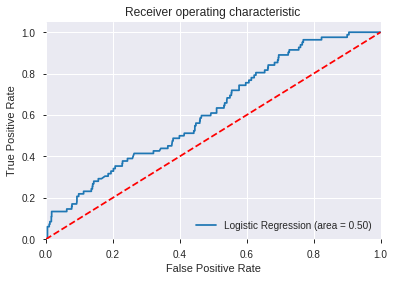

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
%matplotlib inline  
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()